# Preamble

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cmcrameri.cm as cmc
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np
import matplotlib.patches as patches
import scipy.stats as stats
import pandas as pd
import plotly.express as px

from scripts.paths import *
from scripts.dicts import *
# from scripts.open_preprocess_racmo import *


Pathdata: /Volumes/imau01/rapid/RACMO2.3p2/FGRN055


In [2]:
from sum_freshwater_func import *

Import and make masks
Import all FW input source variables for ANNUAL plot
Reading locally reprojected 1k data
Finished reading locally reprojected 1k data
Opening file: 
 /Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/runoff.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz
... 
/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/runoff.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz
Reading locally reprojected 1k data
Finished reading locally reprojected 1k data


In [3]:
from per_source.King2020 import df_D_King_annual_GrIS,ds_D_king_per_basin_sum


In [ ]:
from per_source.Karlsson2021_Basal_Melt import df_Basal_GrIS_annual


Sum is 23.3 km3/yr


# Greenland as a whole

## Annual

In [7]:


ds_run_RACMO = open_compressed_xarray(folder_MARRACMO1km+ "runoff.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz")
ds_run_RACMO['years_since_19580115'] = ds_run_RACMO.time
ds_run_RACMO['time'] = convert_years_to_date(ds_run_RACMO['years_since_19580115'], '1958-01-15')
ds_runoff_RACMO_mean = ds_run_RACMO.sum(dim=['time'])
ds_runoff_RACMO_mean['section_numbers_adjusted'] = ds_runoff_RACMO_mean['runoffcorr'].copy(deep=True)
ds_runoff_RACMO_mean['section_numbers_adjusted'].values = ds_adj_sect['section_numbers_adjusted'].values

for var in ds_masks1k.data_vars:
    ds_runoff_RACMO_mean[var] = ds_runoff_RACMO_mean['runoffcorr'].copy(deep=True)
    ds_runoff_RACMO_mean[var].values = ds_masks1k[var].values
ds_run_RACMO_GrIS_basin = (ds_run_RACMO['runoffcorr'].where(ds_runoff_RACMO_mean['GrIS']==1).groupby(ds_runoff_RACMO_mean['section_numbers_adjusted']).sum()/1e6)
ds_run_RACMO_GIC_basin = (ds_run_RACMO['runoffcorr'].where(ds_runoff_RACMO_mean['GIC']==1).groupby(ds_runoff_RACMO_mean['section_numbers_adjusted']).sum()/1e6)


# select time between 1991 and 2022 for dsPrecipFjordsVolSum and dsPrecipFjordsCARRA_Annual_Sum
dsPrecipFjordsVolSum_selected = dsPrecipFjordsVolSum.sel(time=slice('1991', '2022'))['precipcorr'].to_numpy()
dsPrecipFjordsCARRA_Annual_Sum_selected = dsPrecipFjordsCARRA_Annual_Sum.sel(time=slice('1991', '2022'))['precip'].to_numpy()

err_ratio_precip = ((dsPrecipFjordsVolSum_selected/dsPrecipFjordsCARRA_Annual_Sum_selected)-1).mean()
mean_precip = np.concatenate([dsPrecipFjordsVolSum_selected, dsPrecipFjordsCARRA_Annual_Sum_selected]).mean()
print(f'Error ratio precip: {err_ratio_precip:.2f}')
print("Mean precip: ", mean_precip)

mean_GrIS = np.mean(np.concatenate([ ds_run_MAR_GrIS_basin.sum(dim='section_numbers_adjusted').to_numpy(), ds_run_RACMO_GrIS_basin.sum(dim='section_numbers_adjusted').to_numpy(), dsRunoff_RACMO_1k_YY_GrIS_sum.to_numpy()]))   

mean_GIC = np.mean(np.concatenate([ds_run_MAR_GIC_basin.sum(dim='section_numbers_adjusted').to_numpy(), ds_run_RACMO_GIC_basin.sum(dim='section_numbers_adjusted').to_numpy(), dsRunoff_RACMO_1k_YY_GIC_sum.to_numpy()]))

err_ratio_GrIS = 0.051   #5.1 % difference mean between racmo and mar 1km 
err_ratio_GIC = 0.055  #5.5 % difference mean between racmo and mar 1km 
print(f'Error ratio GIC: {err_ratio_GIC:.2f}')
print(f"Mean GIC: {mean_GIC:.2f}")


Error ratio precip: 0.18
Mean precip:  49.851507408200504
Error ratio GIC: 0.06
Mean GIC: 59.83


# Figure 2: Time series annual 

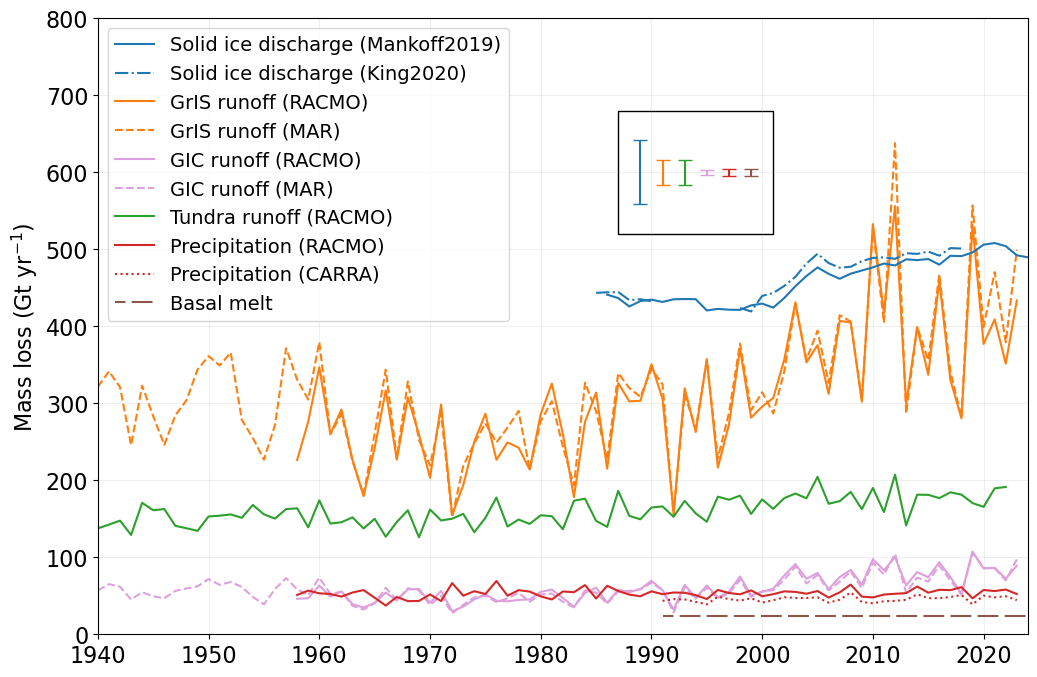

In [ ]:
from scripts.dicts import dictFWcolor
# increase font size
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

def dt_year(ds):
    return pd.to_datetime(ds.time.dt.year,format='%Y')

# Solid ice discharge
ax.plot(pd.to_datetime(dfGISDMankoff.index, format='%Y'), dfGISDMankoff, label='Solid ice discharge (Mankoff2019)', color = dictFWcolor['Solid'], zorder=10)
ax.plot(df_D_King_annual_GrIS.index, df_D_King_annual_GrIS, label='Solid ice discharge (King2020)', color = dictFWcolor['Solid'], linestyle='-.', zorder=10)
# Runoff
ax.plot(dt_year(dsRunoff_RACMO_1k_YY_GrIS_sum), dsRunoff_RACMO_1k_YY_GrIS_sum, label="GrIS runoff (RACMO)", color='tab:orange', linestyle = '-')
ax.plot(dt_year(ds_run_MAR_GrIS_basin), ds_run_MAR_GrIS_basin.sum(dim='section_numbers_adjusted'), label = "GrIS runoff (MAR)", color=dictFWcolor['IceRun'], linestyle = '--')
ax.plot(dt_year(dsRunoff_RACMO_1k_YY_GIC_sum), dsRunoff_RACMO_1k_YY_GIC_sum, label="GIC runoff (RACMO)", color='plum', linestyle = '-')
ax.plot(dt_year(ds_run_MAR_GIC_basin), ds_run_MAR_GIC_basin.sum(dim='section_numbers_adjusted'), label = "GIC runoff (MAR)",color=dictFWcolor['IceCap'], linestyle = '--')
ax.plot(dt_year(dsRunoffTundraSum), dsRunoffTundraSum, label="Tundra runoff (RACMO)", color=dictFWcolor['Tundra'])
# Precipitation
ax.plot(dsPrecipFjordsVolSum.time, dsPrecipFjordsVolSum['precipcorr'], label="Precipitation (RACMO)", color=dictFWcolor['Precip'])
ax.plot(dsPrecipFjordsCARRA_Annual_Sum.time, dsPrecipFjordsCARRA_Annual_Sum['precip'], label="Precipitation (CARRA)", color=dictFWcolor['Precip'], linestyle=":")
# Basal melt
basal_date_range = pd.date_range(start='1991-01-01', end='2023-12-01', freq='MS')
ax.plot(basal_date_range, np.repeat(df_Basal_GrIS_annual, len(basal_date_range)), label="Basal melt", color=dictFWcolor['Basal'], linestyle=(5, (10, 3)))

# Error bars
errorbar_loc = 600
errorbar_loc_x = np.round(np.linspace(1989,1999,6)).astype(int)
ax.errorbar(pd.to_datetime(str(errorbar_loc_x[0])), errorbar_loc, yerr=dfErrorGISDMankoff.mean(), fmt='o', markersize=0.1,  color=dictFWcolor['Solid'], capsize=5)
ax.errorbar(pd.to_datetime(str(errorbar_loc_x[1])), errorbar_loc, yerr=mean_GrIS*err_ratio_GrIS, fmt='o', markersize=0.1, capsize=5, color=dictFWcolor['IceRun'])
ax.errorbar(pd.to_datetime(str(errorbar_loc_x[2])), errorbar_loc, yerr=dsRunoffTundraSum.mean().values*0.10, fmt='o', markersize=0.1, capsize=5, color=dictFWcolor['Tundra'])
ax.errorbar(pd.to_datetime(str(errorbar_loc_x[3])), errorbar_loc, yerr=mean_GIC*err_ratio_GIC, fmt='o', markersize=0.1, capsize=5, color=dictFWcolor['IceCap'])
ax.errorbar(pd.to_datetime(str(errorbar_loc_x[4])), errorbar_loc, yerr=mean_precip*err_ratio_precip/2, fmt='o', markersize=0.1, capsize=5, color=dictFWcolor['Precip'])
ax.errorbar(pd.to_datetime(str(errorbar_loc_x[5])), errorbar_loc, yerr=4.4, fmt='o', markersize=0.1, capsize=5, color=dictFWcolor['Basal'])
rect_x_start = mdates.date2num(pd.to_datetime(str(errorbar_loc_x[0]-2)))
rect_x_end = mdates.date2num(pd.to_datetime(str(errorbar_loc_x[-1]+2)))  # 20 years later
rect_width = rect_x_end - rect_x_start
rect = patches.Rectangle((rect_x_start, 520), rect_width, 160, linewidth=1, edgecolor='k', facecolor='white')
ax.add_patch(rect)

# Layout
ax.set_ylim([0, 800])
years_xlim = [1940, 2023]
ax.set_xlim([pd.Timestamp(str(years_xlim[0])+"-01-01"), pd.Timestamp(str(years_xlim[1])+"-12-31")])
ax.grid(alpha=0.2)
ax.set_ylabel(r"Mass loss (Gt yr$^{-1}$)")
ax.legend(ncols=1, fontsize=14) #bbox_to_anchor=(1.02, 1), loc='upper left',
plt.show()

## Total trends

In [ ]:


fig = go.Figure()

# Add linear trend
for col in df_sum_GIS_55Relative.columns:
    x = df_sum_GIS_55Relative.index.year
    y = df_sum_GIS_55Relative[col].values*100

    x= x[~np.isnan(y)]
    y= y[~np.isnan(y)]

    # Add the original data
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name=col)) #line=dict(color=dictFWcolor_long[col])))
    
    # Calculate the linear trend
    trend = np.polyfit(x, y, 1)
    trendline = np.poly1d(trend)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f'p-value for {col} trend: {p_value}')
    
    # Add the trendline
    fig.add_trace(go.Scatter(x=x, y=trendline(x), mode='lines', name=f'Trend, {slope*10:.1f}%/decade \np={p_value:.3f}', line=dict( dash='dash')))

# update lyaout to plotly white
fig.update_layout(template='plotly_white', title=f"Relative FW input {time_resolution} RACMO2.3p2", width = 1000, height = 500)
fig.show()

p-value for Discharge [Gt yr-1] trend: 0.13378372613255293
p-value for Runoff Ice Caps (RACMO 1km) trend: 0.001604284390712531
p-value for Runoff GrIS (RACMO 1km) trend: 0.04104494911936125
p-value for Runoff Tundra trend: 0.001512502254743405
p-value for Precipitation Fjords trend: 0.012590371752764468


# Per sector

# Figure 4

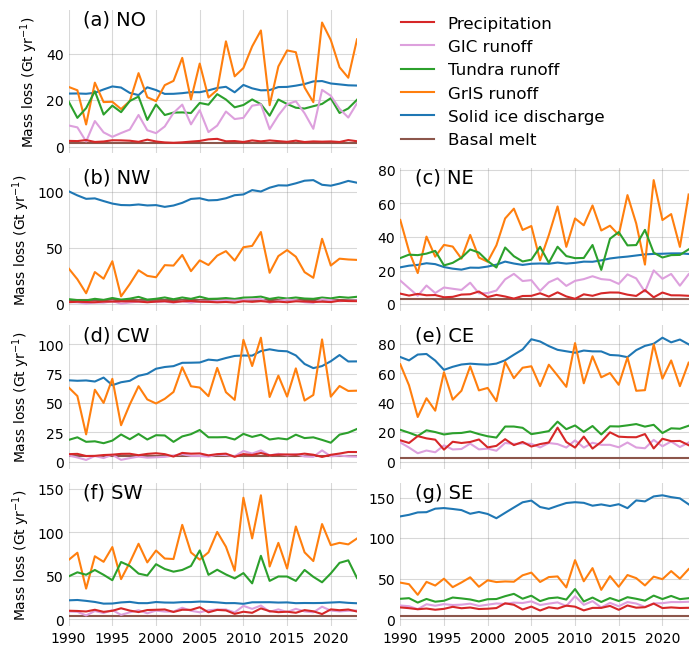

In [ ]:
col_order_yearly = col_order_rel
pd.options.plotting.backend = "matplotlib"
plt.style.use('default')

basin_list_8sub = ['NO','', 'NW', 'NE', 'CW', 'CE', 'SW', 'SE']
basin_alphabet = ['a', '', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

fig, axs = plt.subplots(4,2, sharex=True, figsize=(8, 8), sharey=False)

for i, basin in enumerate(basin_list_8sub):
    ax = axs.flatten()[i]
    
    if basin == '':
        fig.delaxes(axs.flatten()[i])
        continue

    df_single_sector =(dsSectorSum.rename_vars({'Solid Ice discharge (weighted mean)': 'Solid Ice Discharge'})[col_order_yearly].resample(time='YS').mean() * 12).sel(time=slice('1990', '2023')).sel(Basins=basin).to_dataframe().drop(columns='Basins')      

    for var in df_single_sector.columns:
        linestyle = dict_linestyle_FW[var]
        df_single_sector[var].plot(kind='line', ax=ax, legend=False, color=dict_colors_FW[var])

    ax.grid(color = 'gray',alpha = 0.3)
    ymax = df_single_sector.max().max()*1.1
    ax.set_ylim([-ymax/20, ymax])  
    for side in  ['top', 'bottom', 'left', 'right']:
        ax.spines[side].set_visible(False)
    ax.set_xlabel('')
    ax.set_xticks(pd.date_range('1990', '2022', freq='5Y'), minor=True)
    ax.tick_params( length=0)  # Adjust major tick length as needed
    ax.text(0.05, 1, f"({basin_alphabet[i]}) {basin}", fontsize=14, ha='left', va='top', transform=ax.transAxes, color ='black')

handles, labels = axs.flatten()[0].get_legend_handles_labels()
labels = [dict_consistent_naming[label] for label in labels]
axs.flatten()[0].legend(reversed(handles), reversed(labels), bbox_to_anchor=(1.1, 0.5), loc='center left', frameon=False, fontsize=12)
plt.subplots_adjust(wspace=0.15, hspace=0.1)
for i in [0, 2, 4,6]:
    axs.flatten()[i].set_ylabel(r"Mass loss (Gt yr$^{-1}$)")



plt.show()

## Sensitivity 

### Figure 4 with MAR

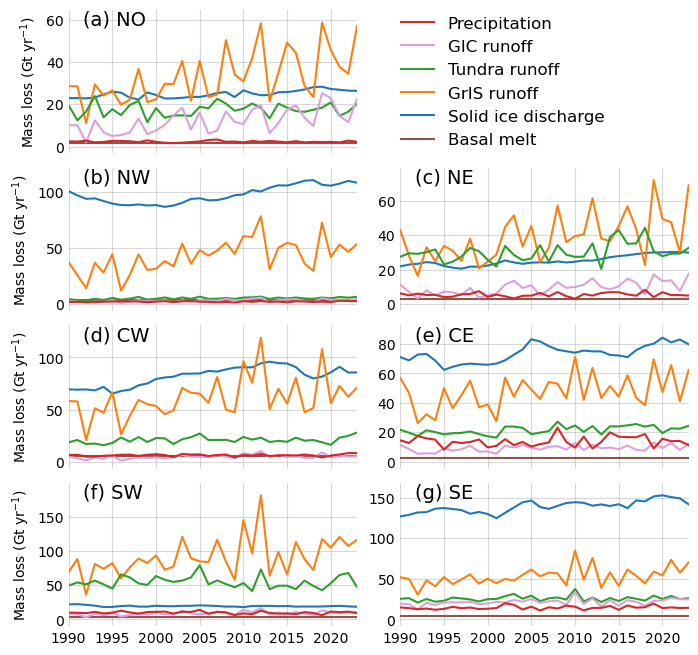

In [25]:
fig, axs = plt.subplots(4,2, sharex=True, figsize=(8, 8), sharey=False)

for i, basin in enumerate(basin_list_8sub):
    ax = axs.flatten()[i]
    if basin == '':
        fig.delaxes(axs.flatten()[i])
        continue
    df_single_sector =(dsSectorSumMAR.rename_vars({'Solid Ice discharge (weighted mean)': 'Solid Ice Discharge'})[col_order_yearly]).sel(time=slice('1990', '2023')).sel(Basins=basin).to_dataframe().drop(columns='Basins')      

    for var in df_single_sector.columns:
        linestyle = dict_linestyle_FW[var]
        line = df_single_sector[var].plot(kind='line', ax=ax, legend=False, color=dict_colors_FW[var])
        line.set_clip_on(False)  # Ensure data outside axis bounds are shown
    ax.set_clip_on(False)
    ax.patch.set_alpha(0.0)

    ax.grid(color = 'gray',alpha = 0.3)
    ymax = df_single_sector.max().max()*1.1
    ax.set_ylim([-ymax/20, ymax])  
    for side in  ['top', 'bottom', 'left', 'right']:
        ax.spines[side].set_visible(False)
    ax.set_xlabel('')
    ax.set_xticks(pd.date_range('1990', '2022', freq='5Y'), minor=True)
    ax.tick_params( length=0)  # Adjust major tick length as needed
    ax.text(0.05, 1, f"({basin_alphabet[i]}) {basin}", fontsize=14, ha='left', va='top', transform=ax.transAxes, color ='black')

handles, labels = axs.flatten()[0].get_legend_handles_labels()
labels = [dict_consistent_naming[label] for label in labels]
axs.flatten()[0].legend(reversed(handles), reversed(labels), bbox_to_anchor=(1.1, 0.5), loc='center left', frameon=False, fontsize=12)
plt.subplots_adjust(wspace=0.15, hspace=0.1)
for i in [0, 2, 4,6]:
    # add ylabel
    axs.flatten()[i].set_ylabel(r"Mass loss (Gt yr$^{-1}$)")
plt.show()

# Figure 3: average seasonal cycle greenland

Text(0.02, 0.95, '(c)')

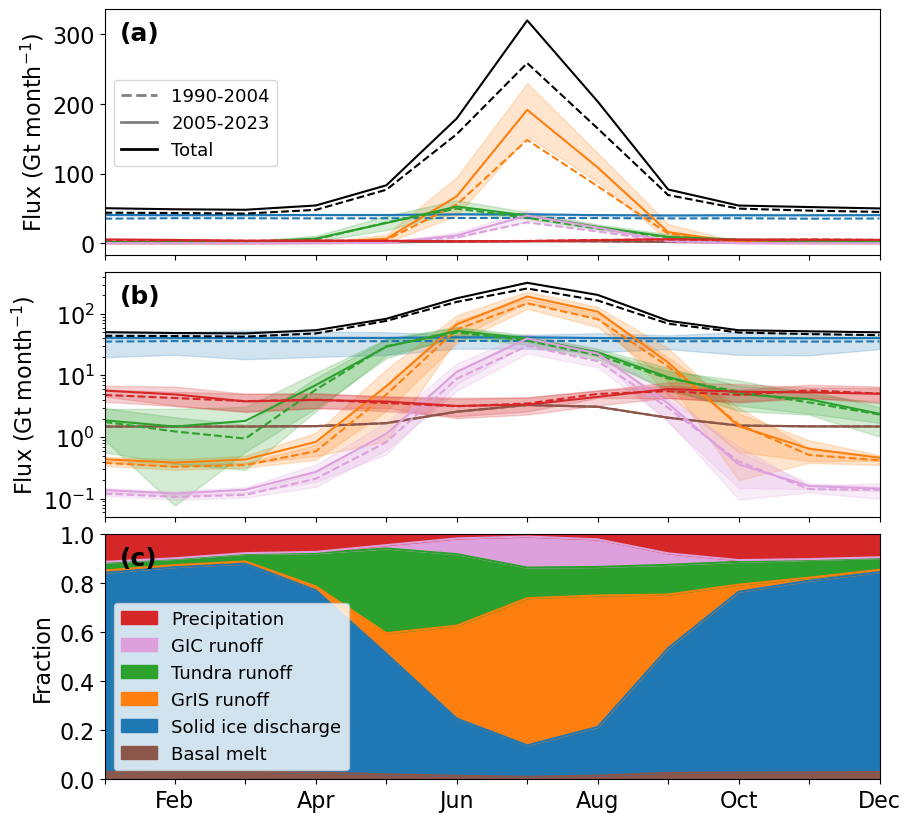

In [29]:
from matplotlib.lines import Line2D
# make a list of all the names of data variables in dsSectorSum

# fontsize
plt.rcParams.update({'font.size': 16})

# change labels of legend from Solid Ice discharge (weighted mean) to Solid Ice discharge 
dict_shorter_name = {'Solid Ice discharge (weighted mean)': 'Solid Ice Discharge'}



fig, axs = plt.subplots(3,1, sharex=True, figsize = (10, 10))

# ax absolute values
axs_log = axs[1]
axs_log.set_yscale('log')
ax = axs[0]

total = xr.DataArray(data = np.zeros(12), dims='month', coords={'month':np.arange(1,13)})
total_before = xr.DataArray(data = np.zeros(12), dims='month', coords={'month':np.arange(1,13)})
data_mean_seasonal_period2

for var in data_mean_seasonal_period2.data_vars:
    # a)
    data_mean_seasonal_period2[var].plot(ax=ax, label=var, color=dict_colors_FW[var])
    ax.fill_between(data_mean_seasonal_period2['month'], data_mean_seasonal_period2[var] - data_std_seasonal_period2[var], data_mean_seasonal_period2[var] + data_std_seasonal_period2[var], alpha=0.2, color=dict_colors_FW[var])
    data_mean_seasonal_period1[var].plot(ax=ax, label=var, linestyle='--', color=dict_colors_FW[var])

    # b)
    data_mean_seasonal_period2[var].plot(ax=axs_log, label=var, color=dict_colors_FW[var])
    axs_log.fill_between(data_mean_seasonal_period2['month'], data_mean_seasonal_period2[var] - data_std_seasonal_period2[var], data_mean_seasonal_period2[var] + data_std_seasonal_period2[var], alpha=0.2, color=dict_colors_FW[var])
    data_mean_seasonal_period1[var].plot(ax=axs_log, label=var, color=dict_colors_FW[var], linestyle='--')
    axs_log.fill_between(data_mean_seasonal_period2['month'], data_mean_seasonal_period1[var] - data_std_seasonal_period1[var], data_mean_seasonal_period1[var] + data_std_seasonal_period1[var], alpha=0.2, color=dict_colors_FW[var])
    
    total_before  = total_before + data_mean_seasonal_period1[var]
    total = total + data_mean_seasonal_period2[var]

handles = [Line2D([0], [0], color='grey', linewidth=2, linestyle='--'),  # Dashed line for 2003-2012
           Line2D([0], [0], color='grey', linewidth=2),  # Solid line for 2013-2022
              Line2D([0], [0], color='black', linewidth=2)]  # Total
ax.legend(handles, [f"{period1['start']}-{period1['end']}", f"{period2['start']}-{period2['end']}", "Total"], bbox_to_anchor=(0.0, 0.75), loc='upper left', fontsize=13)
ax.set_xlabel('')
ax.set_xticklabels([])

total_before.plot(ax=ax, color='black', linestyle='--')
total.plot(ax=ax, color='black')


total_before.plot(ax=axs_log, color='black', linestyle='--')
total.plot(ax=axs_log, color='black')

# do the second in percentage and stacked area
# c)
ax = axs[2]
data_mean_perc = data_mean_seasonal_good_data.to_dataframe()[col_order_rel]
data_mean_perc = (data_mean_perc.T/(data_mean_perc.sum(axis=1).values)).T
data_mean_perc.plot(kind='area', stacked=True, ax=ax, color=[dict_colors_FW[var] for var in data_mean_perc.columns])
handles, labels = ax.get_legend_handles_labels()
labels = [dict_consistent_naming.get(label, label) for label in labels]
ax.legend(reversed(handles), reversed(labels), bbox_to_anchor=(0.0, 0.0), loc='lower left', fontsize=13)
ax.set_xticks(np.arange(1, 13))
ax.set_xlim([1, 12])
ax.set_ylabel('Fraction')
ax.set_ylim([0, 1])
# set vspace
fig.subplots_adjust(hspace=0.07)
for i in range(2):
    axs[i].set_ylabel(r'Flux (Gt month$^{-1}$)')
# set xticks for feb, april, june, august, october, december
axs[-1].set_xticks(np.arange(1, 13, 1))
axs[-1].set_xticklabels(["", "Feb", "", "Apr", "", "Jun", "", "Aug", "", "Oct", "", "Dec"])
axs[-1].set_xlabel('')

# add a) b) c), use bold
fontsize_letter, fontweight = 18, 'bold'
axs[0].text(0.02, 0.95, '(a)', fontsize=fontsize_letter, ha='left', va='top', transform=axs[0].transAxes, fontweight=fontweight)
axs[1].text(0.02, 0.95, '(b)', fontsize=fontsize_letter, ha='left', va='top', transform=axs[1].transAxes, fontweight=fontweight)
axs[2].text(0.02, 0.95, '(c)', fontsize=fontsize_letter, ha='left', va='top', transform=axs[2].transAxes, fontweight=fontweight)




# Relative plot per month - incl. csv

# Figure 5

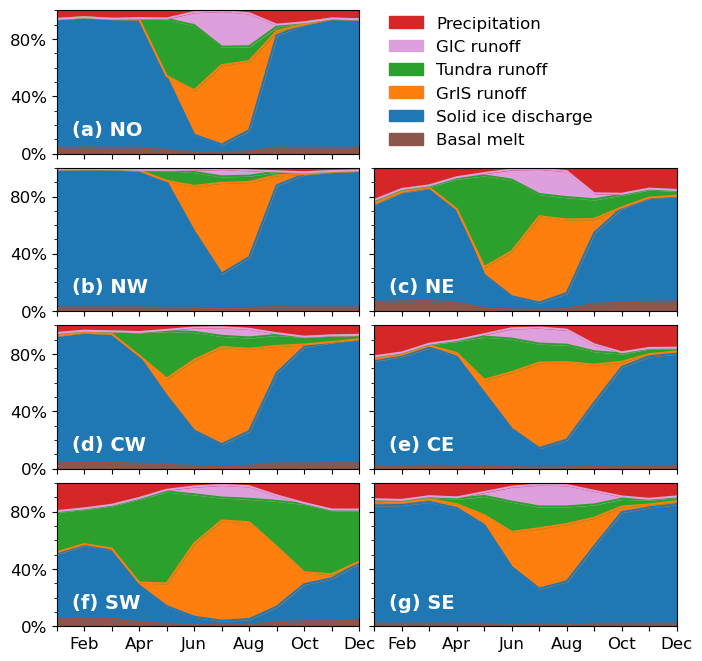

In [37]:
start_year, end_year = '2009', '2023'
 
dsSectorSeasonalCycle = dsSectorSum.copy(deep=True)#.drop('winter_year').drop('summer_year')
# linearly interpolate the Solid Ice discharge (weighted mean) to the same time as the other variables
dsSectorSeasonalCycle['Solid Ice Discharge'] = dsSectorSeasonalCycle['Solid Ice discharge (weighted mean)'].interp(time=dsSectorSeasonalCycle.time)

months = month_names
yticks = np.linspace(0,1,6, endpoint=True)
minor_yticks = np.linspace(0,1,11, endpoint=True)
yticklabels = [f'{ytick:.0%}' if i%1==0 else " " for i, ytick in enumerate(yticks)]

fig, axs = plt.subplots(4,2, sharex=True, figsize=(8, 8), sharey=True)

for i, basin in enumerate(basin_list_8sub):
    ax = axs.flatten()[i]
    if basin == '':
        fig.delaxes(axs.flatten()[i])
        continue
    df_single_sector = dsSectorSeasonalCycle[col_order_rel_sector].sel(time=slice(start_year, end_year)).groupby('time.month').mean().sel(Basins=basin).to_dataframe().drop(columns='Basins')
    df_sector_seasonal_relative = (df_single_sector.T/df_single_sector.sum(axis=1)).T
    (df_sector_seasonal_relative*100).to_csv(f"{csv_seasonal_sector}/{basin}_Seasonal.csv")
    df_sector_seasonal_relative.rename(columns=dict_consistent_naming).plot(kind='area',  ax=ax,  legend=False, color=[dict_colors_FW[var] for var in df_single_sector.columns], stacked=True)

    ax.set_xlim([1, 12])
    months = [month if i%2== 1 else " " for i, month in enumerate(months)]
    ax.set_xticks(np.arange(1, 12+1),months, fontsize=12)
    ax.set_yticks(yticks[:-1:2], yticklabels[:-1:2], fontsize=12)
    ax.set_yticks(minor_yticks, minor=True)
    ax.set_ylim([0, 1]  )
    ax.set_xlabel('')
    ax.text(0.05, 0.1, f"({basin_alphabet[i]}) {basin}", fontsize=14, ha='left', va='bottom', transform=ax.transAxes, color ='white', weight='bold')
handles, labels = axs.flatten()[0].get_legend_handles_labels()
axs.flatten()[0].legend(reversed(handles), reversed(labels), bbox_to_anchor=(1.05, 0.5), loc='center left', frameon=False, fontsize=12)
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.show()



## Sensitivity 
 Adding King solid ice discharge data for sensitivity

### King seasonal in Figure 5

In [42]:

# Add king et al. (2020) dataset
col_order_rel_sector_KING = list((pd.Series(col_order_rel_sector)).replace({'Solid Ice Discharge': 'Solid ice discharge (King2020)'})) 
ds_D_king_per_basin = ds_D_king_per_basin_sum.rename(columns=dict_sections).stack().to_xarray().rename({'Time':'time', 'basin_nr':'Basins'}).to_dataset(name='Solid ice discharge (King2020)')['Solid ice discharge (King2020)'] /12
dsSectorSeasonalCycleKing = dsSectorSeasonalCycle.copy(deep=True).resample(time='MS').mean()
dsSectorSeasonalCycleKing['Solid ice discharge (King2020)'] = ds_D_king_per_basin.resample(time='MS').mean()
# resample at MS to align time
dsSectorSeasonalCycleKing = dsSectorSeasonalCycleKing.resample(time='MS').mean()



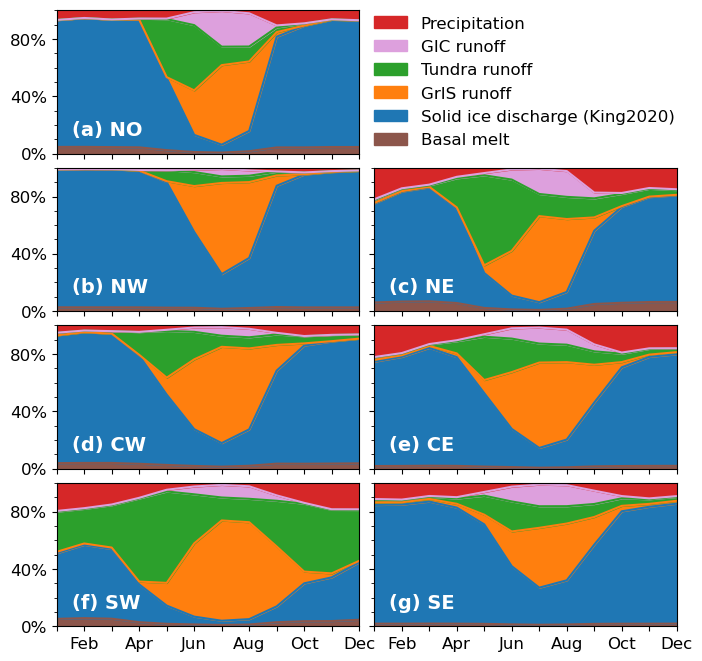

In [ ]:
dict_colors_FW['Solid ice discharge (King2020)'] = dict_colors_FW['Solid Ice Discharge']


fig, axs = plt.subplots(4,2, sharex=True, figsize=(8, 8), sharey=True)

# extend 'Solid Ice discharge' with 'Solid Ice discharge'
for i, basin in enumerate(basin_list_8sub):
    ax = axs.flatten()[i]
    if basin == '':
        fig.delaxes(axs.flatten()[i])
        continue
    df_single_sector = dsSectorSeasonalCycleKing.sel(time=slice(start_year, end_year)).groupby('time.month').mean().sel(Basins=basin).to_dataframe().drop(columns='Basins')[col_order_rel_sector_KING]
    df_sector_seasonal_relative = (df_single_sector.T/df_single_sector.sum(axis=1)).T
    (df_sector_seasonal_relative*100).to_csv(f"{csv_seasonal_sector}/Sensitivity_{basin}_Seasonal.csv")
    df_sector_seasonal_relative.rename(columns=dict_consistent_naming).plot(kind='area',  ax=ax,  legend=False, color=[dict_colors_FW[var] for var in df_single_sector.columns], stacked=True)

    ax.set_xlim([1, 12])
    months = [month if i%2== 1 else " " for i, month in enumerate(months)]
    ax.set_xticks(np.arange(1, 12+1),months, fontsize=12)
    ax.set_yticks(yticks[:-1:2], yticklabels[:-1:2], fontsize=12)
    ax.set_yticks(minor_yticks, minor=True)
    ax.set_ylim([0, 1]  )
    ax.set_xlabel('')
    ax.text(0.05, 0.1, f"({basin_alphabet[i]}) {basin}", fontsize=14, ha='left', va='bottom', transform=ax.transAxes, color ='white', weight='bold')
handles, labels = axs.flatten()[0].get_legend_handles_labels()
axs.flatten()[0].legend(reversed(handles), reversed(labels), bbox_to_anchor=(1., 0.5), loc='center left', frameon=False, fontsize=12)
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.show()

### Total greenland Figure 3
Total greenland sensitivity to solid ice discharge dataset

Text(0.02, 0.95, '(c)')

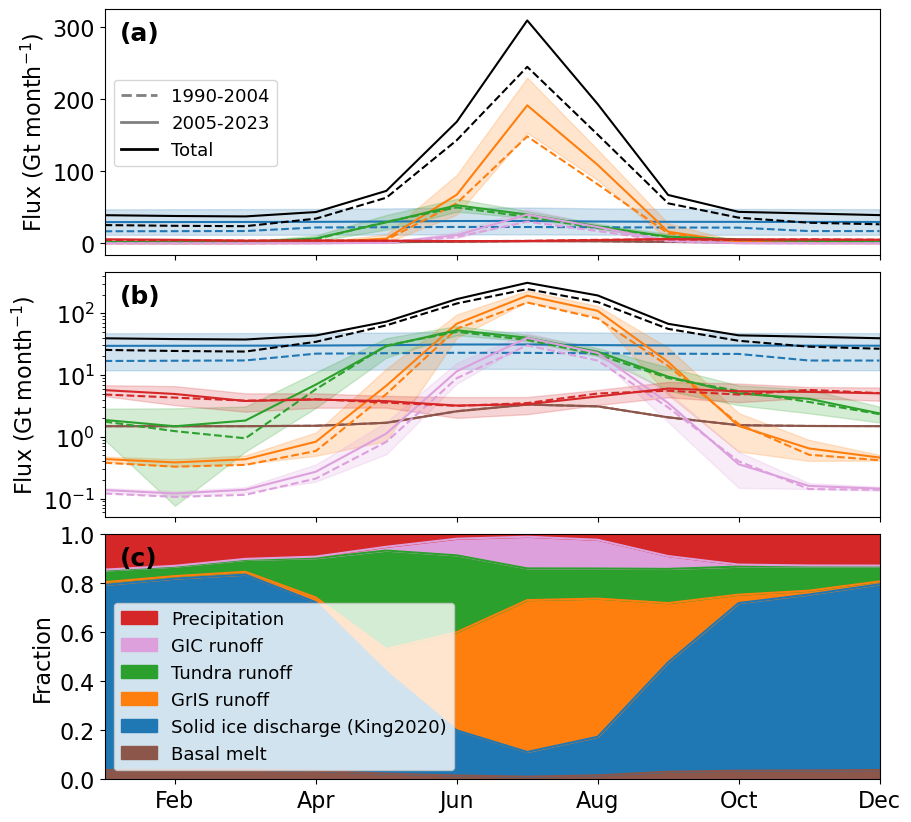

In [46]:
from matplotlib.lines import Line2D
# make a list of all the names of data variables in dsSectorSum

# fontsize
plt.rcParams.update({'font.size': 16})

# change labels of legend from Solid Ice discharge (weighted mean) to Solid Ice discharge 
dict_shorter_name = {'Solid Ice discharge (weighted mean)': 'Solid Ice Discharge'}



fig, axs = plt.subplots(3,1, sharex=True, figsize = (10, 10))

# ax absolute values
axs_log = axs[1]
axs_log.set_yscale('log')
ax = axs[0]

total = xr.DataArray(data = np.zeros(12), dims='month', coords={'month':np.arange(1,13)})
total_before = xr.DataArray(data = np.zeros(12), dims='month', coords={'month':np.arange(1,13)})

data_mean_seasonal_period_King_2 = (
    dsSectorSeasonalCycleKing.sel(time=slice(period2["start"], period2["end"]))
    .sum(dim="Basins")
    .groupby("time.month")
    .mean()
)[col_order_rel_sector_KING]
data_std_seasonal_period_King2 = (
    dsSectorSeasonalCycleKing.sel(time=slice(period2["start"], period2["end"]))
    .sum(dim="Basins")
    .groupby("time.month")
    .std()
)
data_mean_seasonal_period_King_1 = (
    dsSectorSeasonalCycleKing.sel(time=slice(period1["start"], period1["end"]))
    .sum(dim="Basins")
    .groupby("time.month")
    .mean()
)
data_std_seasonal_period_King_1 = (
    dsSectorSeasonalCycleKing.sel(time=slice(period1["start"], period1["end"]))
    .sum(dim="Basins")
    .groupby("time.month")
    .std()
)




for var in data_mean_seasonal_period_King_2.data_vars:
    # a)
    data_mean_seasonal_period_King_2[var].plot(ax=ax, label=var, color=dict_colors_FW[var])
    ax.fill_between(data_mean_seasonal_period_King_2['month'], data_mean_seasonal_period_King_2[var] - data_std_seasonal_period_King2[var], data_mean_seasonal_period_King_2[var] + data_std_seasonal_period_King2[var], alpha=0.2, color=dict_colors_FW[var])
    data_mean_seasonal_period_King_1[var].plot(ax=ax, label=var, linestyle='--', color=dict_colors_FW[var])

    # b)
    data_mean_seasonal_period_King_2[var].plot(ax=axs_log, label=var, color=dict_colors_FW[var])
    axs_log.fill_between(data_mean_seasonal_period_King_2['month'], data_mean_seasonal_period_King_2[var] - data_std_seasonal_period_King2[var], data_mean_seasonal_period_King_2[var] + data_std_seasonal_period_King2[var], alpha=0.2, color=dict_colors_FW[var])
    data_mean_seasonal_period_King_1[var].plot(ax=axs_log, label=var, color=dict_colors_FW[var], linestyle='--')
    # axs_log.fill_between(data_mean_seasonal_period_King_2['month'], data_mean_seasonal_period_King_1[var] - data_std_seasonal_period_King_1[var], data_mean_seasonal_period_King_1[var] + data_std_seasonal_period_King_1[var], alpha=0.2, color=dict_colors_FW[var])
    
    total_before  = total_before + data_mean_seasonal_period_King_1[var]
    total = total + data_mean_seasonal_period_King_2[var]

handles = [Line2D([0], [0], color='grey', linewidth=2, linestyle='--'),  # Dashed line for 2003-2012
           Line2D([0], [0], color='grey', linewidth=2),  # Solid line for 2013-2022
              Line2D([0], [0], color='black', linewidth=2)]  # Total
ax.legend(handles, [f"{period1['start']}-{period1['end']}", f"{period2['start']}-{period2['end']}", "Total"], bbox_to_anchor=(0.0, 0.75), loc='upper left', fontsize=13)
ax.set_xlabel('')
ax.set_xticklabels([])

total_before.plot(ax=ax, color='black', linestyle='--')
total.plot(ax=ax, color='black')


total_before.plot(ax=axs_log, color='black', linestyle='--')
total.plot(ax=axs_log, color='black')

# do the second in percentage and stacked area
# c)
ax = axs[2]
data_mean_perc = data_mean_seasonal_period_King_2.to_dataframe()
data_mean_perc = (data_mean_perc.T/(data_mean_perc.sum(axis=1).values)).T
data_mean_perc.plot(kind='area', stacked=True, ax=ax, color=[dict_colors_FW[var] for var in data_mean_perc.columns])
handles, labels = ax.get_legend_handles_labels()
labels = [dict_consistent_naming.get(label, label) for label in labels]
ax.legend(reversed(handles), reversed(labels), bbox_to_anchor=(0.0, 0.0), loc='lower left', fontsize=13)
ax.set_xticks(np.arange(1, 13))
ax.set_xlim([1, 12])
ax.set_ylabel('Fraction')
ax.set_ylim([0, 1])
# set vspace
fig.subplots_adjust(hspace=0.07)
for i in range(2):
    axs[i].set_ylabel(r'Flux (Gt month$^{-1}$)')
# set xticks for feb, april, june, august, october, december
axs[-1].set_xticks([2, 4, 6, 8, 10, 12])
axs[-1].set_xticklabels(['Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec'])
axs[-1].set_xlabel('')

# add a) b) c), use bold
fontsize_letter, fontweight = 18, 'bold'
axs[0].text(0.02, 0.95, '(a)', fontsize=fontsize_letter, ha='left', va='top', transform=axs[0].transAxes, fontweight=fontweight)
axs[1].text(0.02, 0.95, '(b)', fontsize=fontsize_letter, ha='left', va='top', transform=axs[1].transAxes, fontweight=fontweight)
axs[2].text(0.02, 0.95, '(c)', fontsize=fontsize_letter, ha='left', va='top', transform=axs[2].transAxes, fontweight=fontweight)




### Figure CARRA  5

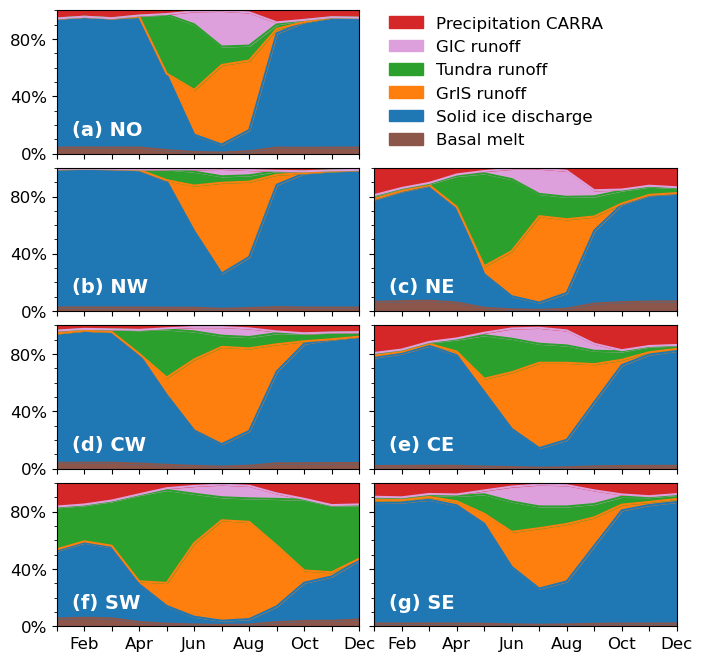

In [ ]:

dsSectorSeasonalCycleCARRA = dsSectorSeasonalCycle.copy(deep=True).drop_vars('Precipitation Fjords')
# dsSectorSeasonalCycleCARRA['Precipitation Fjords CARRA'] =             
dsSectorSeasonalCycleCARRA = xr.merge([dsSectorSeasonalCycleCARRA, dfPrecipFjordsSector_CARRA_month.stack().to_xarray().to_dataset(name="Precipitation Fjords CARRA").rename({"section_numbers_adjusted": "Basins"})])
col_order_rel_sector_CARRA = [item if item != 'Precipitation Fjords' else 'Precipitation Fjords CARRA' for item in col_order_rel_sector]

fig, axs = plt.subplots(4,2, sharex=True, figsize=(8, 8), sharey=True)


# extend 'Solid Ice discharge' with 'Solid Ice discharge'
for i, basin in enumerate(basin_list_8sub):
    ax = axs.flatten()[i]
    if basin == '':
        fig.delaxes(axs.flatten()[i])
        continue
    df_single_sector = dsSectorSeasonalCycleCARRA[col_order_rel_sector_CARRA].sel(time=slice(start_year, end_year)).groupby('time.month').mean().sel(Basins=basin).to_dataframe().drop(columns='Basins')
    df_sector_seasonal_relative = (df_single_sector.T/df_single_sector.sum(axis=1)).T
    df_sector_seasonal_relative.rename(columns=dict_consistent_naming).plot(kind='area',  ax=ax,  legend=False, color=[dict_colors_FW[var] for var in df_single_sector.columns], stacked=True)

    ax.set_xlim([1, 12])
    months = [month if i%2== 1 else " " for i, month in enumerate(months)]
    ax.set_xticks(np.arange(1, 12+1),months, fontsize=12)
    ax.set_yticks(yticks[:-1:2], yticklabels[:-1:2], fontsize=12)
    ax.set_yticks(minor_yticks, minor=True)
    ax.set_ylim([0, 1]  )
    ax.set_xlabel('')
    ax.text(0.05, 0.1, f"({basin_alphabet[i]}) {basin}", fontsize=14, ha='left', va='bottom', transform=ax.transAxes, color ='white', weight='bold')
handles, labels = axs.flatten()[0].get_legend_handles_labels()
axs.flatten()[0].legend(reversed(handles), reversed(labels), bbox_to_anchor=(1.05, 0.5), loc='center left', frameon=False, fontsize=12)
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.show()

